# Convert COMSOL data to PARC data

This notebook is used to convert COMSOL simulation data into tensors suitable for deep learning.
The simulation is a two-phase flow in a porous medium using the phase field method.
It aggregates the data from a parametric sweep into tensors of shape (N_trajectories, N_timesteps, X, Y) for 
each feature.

The input data (exported from COMSOL) is in the form of a csv file with the following columns:
x0 | y0 | t1 | t2 | t3 | ... | tN
x0 | y1 | t1 | t2 | t3 | ... | tN
x0 | y2 | t1 | t2 | t3 | ... | tN
x1 | y0 | t1 | t2 | t3 | ... | tN
x1 | y1 | t1 | t2 | t3 | ... | tN
x1 | y2 | t1 | t2 | t3 | ... | tN
...
xM | yN | t1 | t2 | t3 | ... | tN
where t1, t2, t3, ... are the time steps.

The tensor data is then stored as hdf5 files with the [format used by the well](https://polymathic-ai.org/the_well/data_format/).
In our case, theta (contact angle) and p_cap (capillary pressure) are parameters while the strucID is the ID of the random
geometry used in the simulation. This ID is treated as a trajectory (initial condition).

In [5]:
import re
from pathlib import Path
from typing import Dict, Tuple, Any

import pandas as pd
import numpy as np
import h5py

def search_comsol_data(data_path: Path, params: list[str]) -> Dict[Tuple[int, int, float], Dict[str, Any]]:
    """
    Search through velocities, pressure, and phase_boundary folders to find and group
    files with matching parameter combinations.

    Args:
        data_path (Path): Base path containing the subdirectories

        params (list[str]): List of parameter names to extract from the filenames (e.g. strucID, p_cap, theta)

    Returns:
        Dict: Dictionary with parameter combinations as keys and file information as values
    """
    # Define the subdirectories to search
    subdirs = ["velocities", "pressure", "phase_boundary"]
    data = {}

    # Function to extract parameters from filename
    def extract_params(filename: str, params: list[str]) -> dict:
        param_values = {}
        for param in params:
            param_value = re.search(rf"{param}_(\d+\.?\d*)", filename).group(1)
            match param:
                case "theta":
                    param_values[param] = round(np.rad2deg(float(param_value)), 2)
                case "p_cap":
                    param_values[param] = float(param_value)
                case "strucID":
                    param_values[param] = int(param_value)

        return param_values

    # Search through each subdirectory
    for subdir in subdirs:
        subdir_path = data_path / subdir
        if not subdir_path.exists():
            print(f"Warning: Directory {subdir} not found")
            continue

        files = subdir_path.glob("*.csv")
        for file in files:
            # Extract parameters
            param_values = extract_params(file.stem, params)

            # Create parameter combination key, only include p_cap and theta
            # strucID is not included since we want to aggregate over all strucIDs
            param_key = (param_values["p_cap"], param_values["theta"])

            # Initialize nested dictionaries if they don't exist
            if param_key not in data:
                data[param_key] = {
                    "vel_u": {},
                    "vel_v": {},
                    "pressure": {},
                    "phase_boundary": {},
                }

            strucID = param_values["strucID"]

            # Add file path under appropriate category
            if "vel_u" in str(file):
                data[param_key]["vel_u"][strucID] = file
            elif "vel_v" in str(file):
                data[param_key]["vel_v"][strucID] = file
            elif "pressure" in str(file):
                data[param_key]["pressure"][strucID] = file
            elif "phase_boundary" in str(file):
                data[param_key]["phase_boundary"][strucID] = file

    return data


def load_comsol_csv(file_path: Path) -> np.ndarray:
    """
    Load COMSOL CSV data and reshape it into (time, x, y) format.
    """
    # Read CSV and sort by x then y coordinates
    df = pd.read_csv(file_path, sep=";", dtype=np.float32, header=None)
    df = df.sort_values(by=[df.columns[0], df.columns[1]]).reset_index(drop=True)

    # Get coordinate information
    x_coords = df[0].unique()
    y_coords = df[1].unique()

    # Calculate expected grid size and validate
    grid_size = len(x_coords) * len(y_coords)
    if len(df) != grid_size:
        raise ValueError(
            f"Data grid mismatch: {len(df)} points vs expected {grid_size} ({len(x_coords)}x{len(y_coords)})"
        )

    # Reshape directly to (x, y, time) then transpose to (time, y, x)
    time_steps = df.columns[2:]
    time_data = df[time_steps].values
    data = time_data.reshape(len(x_coords), len(y_coords), len(time_steps))

    return data.transpose(2, 0, 1)

In [6]:
def create_hdf5_dataset(output_path: Path, param_key: tuple, data_dict: dict):
    """
    Create HDF5 file with the specified format.
    """
    p_cap, theta = param_key
    filename = f"porous_twophase_flow_p_cap_{p_cap}_theta_{theta}.hdf5"

    with h5py.File(output_path / filename, "w") as f:
        # Root attributes
        f.attrs["simulation_parameters"] = ["p_cap", "theta"]
        f.attrs["p_cap"] = p_cap
        f.attrs["theta"] = theta
        f.attrs["dataset_name"] = "COMSOL_TwoPhaseFlow"
        f.attrs["grid_type"] = "cartesian"
        f.attrs["n_spatial_dims"] = 2
        f.attrs["n_trajectories"] = data_dict["n_trajectories"]

        # Load data from first file to get dimensions
        x_coords = data_dict["x_coords"]
        y_coords = data_dict["y_coords"]
        time_coords = data_dict["n_timesteps"]

        # Create dimensions group
        dims = f.create_group("dimensions")
        dims.attrs["spatial_dims"] = ["x", "y"]

        time_dset = dims.create_dataset("time", data=time_coords)
        time_dset.attrs["sample_varying"] = False

        x_dset = dims.create_dataset("x", data=x_coords)
        x_dset.attrs["sample_varying"] = False
        x_dset.attrs["time_varying"] = False

        y_dset = dims.create_dataset("y", data=y_coords)
        y_dset.attrs["sample_varying"] = False
        y_dset.attrs["time_varying"] = False

        # Create boundary conditions group
        bc = f.create_group("boundary_conditions")
        x_bc = bc.create_group("x_open")
        x_bc.attrs["associated_dims"] = ["x"]
        x_bc.attrs["associated_fields"] = []
        x_bc.attrs["bc_type"] = "open"
        x_bc.attrs["sample_varying"] = False
        x_bc.attrs["time_varying"] = False

        # y-boundary
        y_bc = bc.create_group("y_wall")
        y_bc.attrs["associated_dims"] = ["y"]
        y_bc.attrs["associated_fields"] = []
        y_bc.attrs["bc_type"] = "wall"
        y_bc.attrs["sample_varying"] = False
        y_bc.attrs["time_varying"] = False


        # Create scalars group
        scalars = f.create_group("scalars")
        scalars.attrs["field_names"] = ["p_cap", "theta"]

        p_cap_dset = scalars.create_dataset("p_cap", data=p_cap)
        p_cap_dset.attrs["sample_varying"] = False
        p_cap_dset.attrs["time_varying"] = False

        theta_dset = scalars.create_dataset("theta", data=theta)
        theta_dset.attrs["sample_varying"] = False
        theta_dset.attrs["time_varying"] = False

        # Create t0_fields group for pressure
        t0_fields = f.create_group("t0_fields")
        t0_fields.attrs["field_names"] = ["pressure", "phase_boundary"]

        # Load and store pressure field
        pressure_dset = t0_fields.create_dataset(
            "pressure", data=data_dict["pressure"]
        )
        pressure_dset.attrs["dim_varying"] = [True, True]
        pressure_dset.attrs["sample_varying"] = True
        pressure_dset.attrs["time_varying"] = True

        phase_boundary_dset = t0_fields.create_dataset(
            "phase_boundary", data=data_dict["phase_boundary"]
        )
        phase_boundary_dset.attrs["dim_varying"] = [True, True]
        phase_boundary_dset.attrs["sample_varying"] = True
        phase_boundary_dset.attrs["time_varying"] = True

        # Create t1_fields group for velocities
        t1_fields = f.create_group("t1_fields")
        t1_fields.attrs["field_names"] = ["velocity"]

        # Load velocity components
        velocity_dset = t1_fields.create_dataset(
            "velocity", data=data_dict["velocity"]
        )
        velocity_dset.attrs["dim_varying"] = [True, True]
        velocity_dset.attrs["sample_varying"] = True
        velocity_dset.attrs["time_varying"] = True

        # Create empty t2_fields group
        t2_fields = f.create_group("t2_fields")
        t2_fields.attrs["field_names"] = []


In [ ]:
# Load the data
raw_data_path = Path("/home/flwi01/Coding/MetaPARC/data/raw_comsol")
data_path = Path("/home/flwi01/Coding/MetaPARC/data/tasks/datasets/porous_twophase_flow/data")
data_path.mkdir(parents=True, exist_ok=True)
param_names = ["strucID", "p_cap", "theta"]

data_files: dict[tuple[int, int], dict[str, dict[int, Path]]] = search_comsol_data(raw_data_path, param_names)

for params_key, features in data_files.items():
    data = {}
    data["params"] = params_key
    for feature_name, trajectories in features.items():
        trajectory_data = []
        for trajectory_id, file_path in trajectories.items():
            feature_array = load_comsol_csv(file_path)
            trajectory_data.append(feature_array)


        trajectory_data = np.stack(trajectory_data, axis=0) # (n_trajectories, n_timesteps, x, y)
        data[feature_name] = trajectory_data

    # Add metadata from the last trajectory
    data["n_trajectories"] = trajectory_data.shape[0]
    data["n_timesteps"] = trajectory_data.shape[1]
    data["x_coords"] = trajectory_data.shape[2]
    data["y_coords"] = trajectory_data.shape[3]

    # join vel_u and vel_v
    data["velocity"] = np.stack([data["vel_u"], data["vel_v"]], axis=-1)
    # remove vel_u and vel_v
    del data["vel_u"]
    del data["vel_v"]

    create_hdf5_dataset(data_path, params_key, data)

    # data_path.mkdir(parents=True, exist_ok=True)
    # np.save(data_path / f"p_cap_{params_key[1]}_theta_{params_key[2]}.npy", data)


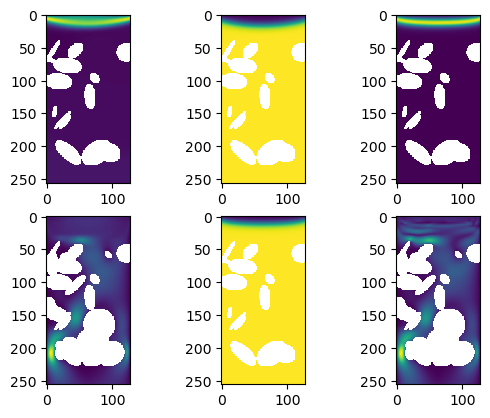

In [15]:
import matplotlib.pyplot as plt

# Plot 2 data timesteps to check if correct for each feature

with h5py.File(data_path / "porous_twophase_flow_p_cap_0_theta_110.hdf5", "r") as f:
    pressure = f["t0_fields/pressure"][:]
    phase_boundary = f["t0_fields/phase_boundary"][:]
    velocity = f["t1_fields/velocity"][:]

vel_mag = np.linalg.norm(velocity, axis=-1)

traj_id = 0

fig, axs = plt.subplots(2, 3)
axs[0, 0].imshow(pressure[traj_id,100, :, :])
axs[0, 1].imshow(phase_boundary[traj_id,100, :, :])
axs[1, 0].imshow(vel_mag[traj_id,100, :, :])

axs[0, 2].imshow(pressure[traj_id,300, :, :])
axs[1, 1].imshow(phase_boundary[traj_id,300, :, :])
axs[1, 2].imshow(vel_mag[traj_id,300, :, :])

plt.show()


### Split into test/train/validation

Finally, we can split the data into the three different sets. We use the same split (0.8, 0.1, 0.1) as the well.

In [ ]:
import shutil
import random
from pathlib import Path

def split_datasets(data_path: Path, train_ratio: float = 0.8, val_ratio: float = 0.1, test_ratio: float = 0.1):
    """Split hdf5 files into train/val/test directories.
    
    Parameters
    ----------
    data_path : Path
        Path to directory containing hdf5 files
    train_ratio : float, optional
        Ratio of files to use for training, by default 0.8
    val_ratio : float, optional
        Ratio of files to use for validation, by default 0.1
    test_ratio : float, optional
        Ratio of files to use for testing, by default 0.1
    """
    # Create subdirectories
    train_dir = data_path / "train"
    val_dir = data_path / "val" 
    test_dir = data_path / "test"
    
    for dir in [train_dir, val_dir, test_dir]:
        dir.mkdir(exist_ok=True)
    
    # Get list of hdf5 files
    hdf5_files = list(data_path.glob("*.hdf5"))
    
    # Shuffle files
    random.shuffle(hdf5_files)
    
    # Calculate split indices
    n_files = len(hdf5_files)
    n_train = int(n_files * train_ratio)
    n_val = int(n_files * val_ratio)
    
    # Split files
    train_files = hdf5_files[:n_train]
    val_files = hdf5_files[n_train:n_train + n_val]
    test_files = hdf5_files[n_train + n_val:]
    
    # Move files to respective directories
    for file in train_files:
        shutil.copy2(file, train_dir / file.name)
    
    for file in val_files:
        shutil.copy2(file, val_dir / file.name)
        
    for file in test_files:
        shutil.copy2(file, test_dir / file.name)
        
    print(f"Split {n_files} files into:")
    print(f"Train: {len(train_files)} files")
    print(f"Validation: {len(val_files)} files") 
    print(f"Test: {len(test_files)} files")

# Split the datasets
split_datasets(data_path)
